<a href="https://colab.research.google.com/github/brandinho/Baysian-Q-Learning/blob/master/Regret.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluation of Q-Learning Algorithms

We evaluate various Q-Learning algirithms by comparing their cumulative regret as training progresses. A lower and flatter curve indicates that the agent is better at solving the exploration vs exploitation problem.

In [1]:
import numpy as np
from math import erf
from scipy.special import ndtri
from tqdm import tqdm
import matplotlib.pyplot as plt

First, we define our Q-Learning agent, which we call "TabularAgent" because we apply it to a tabular setting (Grid World). The agent is flexible enough to accomodate various Q-Learning approaches.

In [8]:
class TabularAgent():
  def __init__(self, grid_template, starting_location, possible_actions, epsilon_greedy, epsilon_decay, 
               epsilon_decay_rate = 0.001, epsilon = 0.1, gamma = 0.99, alpha = 0.05, is_bayesian = True, 
               upper_confidence_bound = False, myopic_vpi = True):
    self.position = starting_location
    self.possible_actions = possible_actions
    self.n_actions = len(self.possible_actions)
    
    starting_mean = 0
    starting_var = 50
    
    height = grid_template.shape[0]
    width = grid_template.shape[1]

    self.Q_table_mean = {}
    self.Q_table_var = {}
    self.reward_variance_tracker = {}
    for x in range(width):
      for y in range(height):
        for action in self.possible_actions:
          current_key = self.key_format((y, x), action)
          self.Q_table_mean[current_key] = starting_mean
          self.Q_table_var[current_key] = starting_var
          self.reward_variance_tracker[current_key] = {"variance": 0, "mean": None, "SSE": 0, "idx": 0}

    self.epsilon_greedy = epsilon_greedy
    self.epsilon_decay = epsilon_decay
    self.epsilon_decay_rate = epsilon_decay_rate
    self.epsilon = epsilon
    self.gamma = gamma
    self.alpha = alpha
    
    self.is_bayesian = is_bayesian
    self.upper_confidence_bound = upper_confidence_bound
    self.myopic_vpi = myopic_vpi
    self.episode = 0
        
  @staticmethod
  def key_format(position, action):
    return "{} {}".format(position, action)   

  @staticmethod
  def softmax(x):
    return np.exp(x) / np.sum(np.exp(x))

  @staticmethod
  def phi(x, mu, sigma):
      "Much faster computation compared to scipy.stats norm.cdf"
      return (1 + erf((x - mu) / sigma / np.sqrt(2))) / 2
  
  @staticmethod
  def phi_inverse(alpha):
      return ndtri(alpha)
  
  @staticmethod
  def lower_phi(y):
      return (1 / np.sqrt(2 * np.pi)) * np.exp(-y**2/2)
  
  def expected_value(self, mu, sigma, upper_bound = None, lower_bound = None):
      "Much faster computation compared to scipy.stats norm.expect"
      assert upper_bound is not None or lower_bound is not None
      if upper_bound is not None:
          alpha = 1 - self.phi(upper_bound, mu, sigma)
          direction = -1
      elif lower_bound is not None:
          alpha = self.phi(lower_bound, mu, sigma)
          direction = 1
          
      if alpha == 1:
          return 0
      elif alpha == 0:
          return mu
      else:
          return (mu + direction * sigma * ((self.lower_phi(self.phi_inverse(alpha))) / (1 - alpha))) * (1 - alpha)        

  def get_myopic_vpi(self, a, best_action, second_best_action):
      current_mu = self.Q_table_mean[self.key_format(self.position, a)]
      current_sigma = np.sqrt(self.Q_table_var[self.key_format(self.position, a)])
      if a == best_action:
          second_best_mu = self.Q_table_mean[self.key_format(self.position, second_best_action)]
          probability_of_gain = self.phi(second_best_mu, current_mu, current_sigma)
          expected_better_value = self.expected_value(current_mu, current_sigma, upper_bound = second_best_mu)
          vpi = second_best_mu * probability_of_gain - expected_better_value
      else:
          best_mu = self.Q_table_mean[self.key_format(self.position, best_action)]
          probability_of_gain = 1 - self.phi(best_mu, current_mu, current_sigma)
          expected_better_value = self.expected_value(current_mu, current_sigma, lower_bound = best_mu)
          vpi = expected_better_value - best_mu * probability_of_gain
      return vpi

  def update_reward_variance(self, state, action, reward):
    key = self.key_format(state, action)
    self.reward_variance_tracker[key]["idx"] += 1
    idx = self.reward_variance_tracker[key]["idx"]
    if self.reward_variance_tracker[key]["mean"] is None:
      self.reward_variance_tracker[key]["mean"] = reward
    error = reward - self.reward_variance_tracker[key]["mean"]
    
    self.reward_variance_tracker[key]["mean"] += error / (idx + 1)
    self.reward_variance_tracker[key]["SSE"] += error * (reward - self.reward_variance_tracker[key]["mean"])
    self.reward_variance_tracker[key]["variance"] = self.reward_variance_tracker[key]["SSE"] / (idx + 1)

  def sample_Q(self, key):
    return np.random.normal(loc = self.Q_table_mean[key], scale = np.sqrt(self.Q_table_var[key]))

  def get_action(self, stochastic = True):
    action = np.zeros(self.n_actions)
    if stochastic and self.is_bayesian:
      if self.upper_confidence_bound:
        Qvalue_list = [self.Q_table_mean[self.key_format(self.position, a)] + np.sqrt(self.Q_table_var[self.key_format(self.position, a)]) * 2 for a in self.possible_actions]
      elif self.myopic_vpi:
        Q_means = [self.Q_table_mean[self.key_format(self.position, a)]for a in self.possible_actions]
        best_action = self.possible_actions[np.argmax(Q_means)]
        second_best_action = self.possible_actions[np.argsort(Q_means)[-2]]
        Qvalue_list = [self.Q_table_mean[self.key_format(self.position, a)] + self.get_myopic_vpi(a, best_action, second_best_action) for a in self.possible_actions]        
      else:
        Qvalue_list = [self.sample_Q(self.key_format(self.position, a)) for a in self.possible_actions]
    elif stochastic and self.epsilon_greedy and np.random.rand() < self.epsilon:
      Qvalue_list = np.random.normal(size = len(self.possible_actions))
    else:
      Qvalue_list = [self.Q_table_mean[self.key_format(self.position, a)] for a in self.possible_actions]
    action[np.argmax(Qvalue_list)] = 1
    return action
  
  def change_position(self, current_position, direction):
    if direction == "Left":
      current_position = (current_position[0], current_position[1] - 1)
    elif direction == "Right":
      current_position = (current_position[0], current_position[1] + 1)
    elif direction == "Up":
      current_position = (current_position[0] - 1, current_position[1])
    elif direction == "Down":
      current_position = (current_position[0] + 1, current_position[1])
    return current_position

  def move(self, action):
    self.position = self.change_position(self.position, action)
    return self.position        
      
  def learn(self, state, action, reward, next_state):
    # Lookahead Mean
    old_Q_value_mean = self.Q_table_mean[self.key_format(state, action)]
    next_action = self.possible_actions[np.argmax([self.Q_table_mean[self.key_format(next_state, a)] for a in self.possible_actions])]
    next_Q_value_mean = self.Q_table_mean[self.key_format(next_state, next_action)]
    lookahead_Q_value_mean = reward + self.gamma * next_Q_value_mean
    
    if self.is_bayesian:
      # Lookahead Variance
      self.update_reward_variance(state, action, reward)
      reward_var = self.reward_variance_tracker[self.key_format(state, action)]["variance"]
      old_Q_value_var = self.Q_table_var[self.key_format(state, action)] + 0.001 # The constant prevents the agent's uncertainty from going to 0 (philosophically we don't believe it should ever reach 0)
      next_Q_value_var = self.Q_table_var[self.key_format(next_state, next_action)]
      lookahead_Q_value_var = reward_var + self.gamma * next_Q_value_var            
    
    # Update Mean and Variance
    if self.is_bayesian:
      alpha = old_Q_value_var / (old_Q_value_var + lookahead_Q_value_var)
    else:
      alpha = self.alpha
    Q_key = self.key_format(state, action)
    self.Q_table_mean[Q_key] = (1 - alpha) * old_Q_value_mean + alpha * lookahead_Q_value_mean
    if self.is_bayesian:
      self.Q_table_var[Q_key] = alpha * lookahead_Q_value_var


Next, we want to create the environment for the agent to navigate through. If you are feeling adventurous, you can change the location of the danger zone and the parameters of the reward distributions! We initially named the danger zone the "random forest" because the rewards that the agent received were largely unknown... and also we thought it was a clever play on words... But in the paper, we ultimately decided to call it the danger zone to avoid confusion.

In [3]:
class Environment():
  def __init__(self, agent_inputs, height, width):        
    assert width > 2 and height > 2        
    self.height = height
    self.width = width
    self.grid_template = np.zeros((self.height, self.width))
    self.state_visitations = self.grid_template.copy()
    self.danger_probability = 0.1
    
    ### Define the area for the danger zone
    self.height_anchor = 1
    self.height_offset = 3
    self.width_anchor = 1
    self.width_offset = 2
    
    self.dangerY_range = range(self.height_anchor, self.height_anchor + self.height_offset)
    self.dangerX_range = range(self.width_anchor, self.width_anchor + self.width_offset)
    self.dangerY_len, self.dangerX_len = len(self.dangerY_range), len(self.dangerX_range)
    
    ### Define some important locations
    self.starting_location = (0, 0)
    self.goal_location = (0, self.width-1)
    self.cliff_locations = np.array([(0, cliff) for cliff in range(1, self.width-1)])
    
    ### Define some rewards
    self.goal_reward = 50
    self.cliff_reward = -50
    self.roaming_loc, self.roaming_scale = -2, 2
    self.danger_loc, self.danger_scale = -15, 15
    self.regret_baseline = self.roaming_loc * 16 + self.goal_reward
    
    ### Addign the rewards to the grid
    self.set_default_grid_rewards()
    self.cumulative_rewards = 0
    self.cumulative_expected_rewards = 0
    self.n_moves = 0
    self.max_moves = self.height * self.width

    self.vertical_min, self.vertical_max = 0, self.height-1
    self.horizontal_min, self.horizontal_max = 0, self.width-1
    self.possible_actions = np.array(["Left", "Right", "Up", "Down"])

    self.agent = TabularAgent(self.grid_template, self.starting_location, self.possible_actions, 
                              agent_inputs["Epsilon-Greedy"], agent_inputs["Epsilon Decay"], 
                              agent_inputs["Epsilon Decay Rate"], agent_inputs["Epsilon"], 
                              agent_inputs["Gamma"], agent_inputs["Alpha"], agent_inputs["Bayesian"], 
                              agent_inputs["Upper Confidence Bound"], agent_inputs["Myopic-VPI"])
    self.nullify_gameover_Q_values()
      
  def nullify_gameover_Q_values(self):
    for a in self.possible_actions:
      key = self.agent.key_format(self.goal_location, a)
      self.agent.Q_table_mean[key] = 0
      self.agent.Q_table_var[key] = 1

  def set_default_grid_rewards(self):
    self.grid_rewards = self.grid_template.copy()
    self.grid_rewards[:] = np.random.normal(self.roaming_loc, self.roaming_scale, size = self.height * self.width).reshape(self.height, self.width)
    self.grid_rewards[self.goal_location] = self.goal_reward
    self.grid_rewards[tuple(self.cliff_locations.T)] = self.cliff_reward       
      
  def set_random_cliffs(self):
    danger_conditional = np.ones_like(self.grid_template)        
    random_numbers = np.random.rand(self.dangerY_len * self.dangerX_len).reshape(self.dangerY_len, self.dangerX_len)
    danger_conditional[self.dangerY_range[0]:self.dangerY_range[-1]+1, self.dangerX_range[0]:self.dangerX_range[-1]+1] = random_numbers
    self.grid_rewards[danger_conditional < self.danger_probability] = self.cliff_reward

  def set_random_forest_rewards(self):
    random_rewards = np.random.normal(loc = self.danger_loc, scale = self.danger_scale, size = self.height_offset * self.width_offset)
    random_rewards = random_rewards.reshape(self.height_offset, self.width_offset)
    self.grid_rewards[self.dangerY_range[0]:self.dangerY_range[-1]+1, 
                      self.dangerX_range[0]:self.dangerX_range[-1]+1] = random_rewards

  @staticmethod
  def onehot_to_index(onehot):
    return np.where(onehot==1)[0][0]  
  
  def check_valid_action(self, action_onehot):
    assert len(action_onehot) == len(self.possible_actions)
    action = self.possible_actions[self.onehot_to_index(action_onehot)]
    valid_action = True
    if action == "Left":
      if self.agent.position[1] == 0:
        valid_action = False
    elif action == "Right":
      if self.agent.position[1] == self.width - 1:
        valid_action = False
    elif action == "Up":
      if self.agent.position[0] == 0:
        valid_action = False
    elif action == "Down":
      if self.agent.position[0] == self.height - 1:
        valid_action = False
    return valid_action, action

  def move(self, stochastic = True, verbose = False, learn = True):
    state = self.agent.position
    self.state_visitations[state[0], state[1]] += 1
    action_onehot = self.agent.get_action(stochastic)
    valid_action, action = self.check_valid_action(action_onehot)
    if valid_action:            
      next_state = self.agent.move(action)
    else:
      next_state = self.agent.position
    self.n_moves += 1
    
    ### Reset the rewards/punishments in the random forest
    self.set_default_grid_rewards()
    self.set_random_forest_rewards()
        
    reward = self.grid_rewards[next_state]
    self.cumulative_rewards += reward
    if next_state == self.goal_location:
      self.cumulative_expected_rewards += self.goal_reward
    elif next_state in self.cliff_locations.tolist():
      self.cumulative_expected_rewards += self.cliff_reward
    elif (next_state[0] >= self.dangerY_range[0] and next_state[0] < self.dangerY_range[-1] and
          next_state[1] >= self.dangerX_range[0] and next_state[1] < self.dangerX_range[-1]):
      self.cumulative_expected_rewards += self.danger_loc
    else:
      self.cumulative_expected_rewards += self.roaming_loc
    
    if learn:
      self.agent.learn(state, action, reward, next_state)  

    done_game = False
    if self.agent.position == self.goal_location:
      game_end_text = "You won the game!! Congratz!"
      done_game = True
    if any([self.agent.position == tuple(cliff) for cliff in self.cliff_locations]):
      game_end_text = "You fell off the cliff!"
      done_game = True
    if self.n_moves >= self.max_moves:
      game_end_text = "You timed out!"
      done_game = True
        
    if done_game:
      self.state_visitations[next_state[0], next_state[1]] += 1
      if self.agent.epsilon_decay:
        self.agent.epsilon = max(0.02, self.agent.epsilon - self.agent.epsilon_decay_rate)
      if verbose:
        print(game_end_text)
    return done_game        
  
  def reset(self):
    self.agent.position = self.starting_location
    self.cumulative_rewards = 0
    self.cumulative_expected_rewards = 0
    self.n_moves = 0
    self.agent.episode += 1

  def update_environment_visualization(self, ax):
    self.env_map.set_data(self.grid_rewards)

Below is the training loop that records cumulative regret

In [4]:
def get_regret_from_training(env, episodes, label):
  total_returns = []
  cumulative_regret = []
  for e in tqdm(range(episodes)):
    env.reset()
    done_game = False
    while not done_game:
      done_game = env.move()
    total_returns.append(env.cumulative_rewards)
    cumulative_regret.append(env.regret_baseline - env.cumulative_expected_rewards)
  plt.plot(np.cumsum(cumulative_regret), label = label)

Define a function to get model parameters given the chosen model (mostly to clean up the code in the last section):

In [5]:
def get_model_parameters(model_name):
  if "Epsilon" not in model_name:
    is_bayesian = True
    epsilon_greedy = False
    epsilon_decay = False
  else:
    is_bayesian = False
    epsilon_greedy = True
    if "Decay" in model_name:
      epsilon_decay = True
    else:
      epsilon_decay = False

  if "UCB" in model_name:
    upper_confidence_bound = True
  else:
    upper_confidence_bound = False

  if "Myopic-VPI" in model_name:
    myopic_vpi = True
  else:
    myopic_vpi = False

  return epsilon_greedy, epsilon_decay, is_bayesian, upper_confidence_bound, myopic_vpi

Define the parameters of the benchmark that you want to compare our approach against

In [6]:
benchmark_agent_inputs = {
            "Bayesian": False, 
            "Upper Confidence Bound": False,  
            "Myopic-VPI": False,
            "Epsilon-Greedy": False, 
            "Epsilon Decay": False,
            "Epsilon": 0.1, 
            "Epsilon Decay Rate": 0.0001,
            "Gamma": 0.99, 
            "Alpha": 0.05
        }

Now, we're ready to play around with some parameters and see how our agent performs relative to any benchmark!!

100%|██████████| 5000/5000 [00:18<00:00, 272.52it/s]


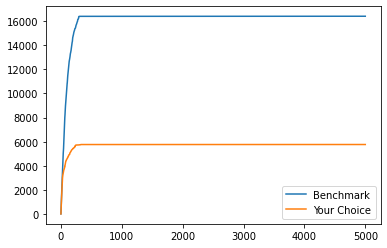

In [9]:
#@title Play Around with the Parameters { form-width: "400px" }

model_name = "Myopic-VPI" #@param ["Epsilon-Greedy", "Epsilon-Greedy (Decay)", "Bayes-UCB", "Q-Value Sampling", "Myopic-VPI"] {type:"string"}

epsilon_greedy, epsilon_decay, is_bayesian, upper_confidence_bound, myopic_vpi = get_model_parameters(model_name)

epsilon = 0.1 #@param {type:"slider", min:0, max:1, step:0.01}
epsilon_decay_rate = 0.01 #@param {type:"slider", min:0.0001, max:0.01, step:0.0001}
gamma = 0.99 #@param {type:"slider", min:0, max:1, step:0.01}
alpha = 0.05 #@param {type:"slider", min:0, max:1, step:0.01}

agent_inputs = {
            "Bayesian": is_bayesian, "Upper Confidence Bound": upper_confidence_bound, "Myopic-VPI": myopic_vpi,
            "Epsilon-Greedy": epsilon_greedy, "Epsilon Decay": epsilon_decay, "Epsilon": epsilon, 
            "Epsilon Decay Rate": epsilon_decay_rate, "Gamma": gamma, "Alpha": alpha
        }

env = Environment(benchmark_agent_inputs, height = 6, width = 10)
get_regret_from_training(env, episodes = 5000, label = "Benchmark")

env = Environment(agent_inputs, height = 6, width = 10)
get_regret_from_training(env, episodes = 5000, label = "Your Choice")

plt.legend()